In [1]:
import numpy as np
import pandas as pd
import re
import emoji
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf

First we set up the environment with necessary imports for performing NLP and machine learning tasks related to text vectorization, topic modeling, word cloud generation, and sequence padding. We will add to these on the later codes.

The installations and downloads in the comments are the ones that I needed in order for my code to run, put into comments just for an overview of the steps, but since they are already up to date I decided to not make them runnable.

In [2]:
#pip install sentencepiece
#!pip install tensorflow

In [3]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [4]:
#!pip install tensorflow

First I found a dataset from Kaggle called: Twitter US Airline Sentiment, by CrowdFlower.

In [5]:
airline_tweets = pd.read_csv("C:\\Users\\user\\Desktop\\Tweets.csv")
airline_tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


The dataset contains information about tweets related to customer reviews about US airlines and their associated sentiments concerning the columns:

- `tweet_id`: The tweet's ID.
- `airline_sentiment`: The sentiment associated with the tweet, which can be one of the following categories: "Negative", "Neutral", or "Positive".
- `airline_sentiment_confidence`: The confidence level of the sentiment classification, indicating the algorithm's certainty about the sentiment expressed in the tweet.
- `negativereason`:  The reason cited for negative sentiment, if applicable. This column may be empty for positive or neutral tweets.
- `negativereason_confidence`: The confidence level of the negative sentiment reason classification, indicating the algorithm's certainty about the reason for negative sentiment.
- `airline`: The airline mentioned in the tweet.
- `airline_sentiment_gold`: Gold standard sentiment for validation (if available)
- `name`: The Twitter handle of the user who posted the tweet.
- `negativereason_gold`: gold standard label for the reason behind negative sentiment in a tweet
- `retweet_count`: The number of retweets for the tweet.
- `text`: The actual text content of the tweet.
- `tweet_coord`: The coordinates of the tweet, if available.
- `tweet_created`:  The timestamp indicating when the tweet was created.
- `tweet_location`: The location metadata associated with the tweet, if available.
- `user_timezone`: The timezone of the user who posted the tweet.


The dataset has 14,640 rows and 15 columns.

In [6]:
#PREPROCESSING

In [7]:
confidence_threshold = 0.6

airline_tweets = airline_tweets.drop(airline_tweets.query("airline_sentiment_confidence < @confidence_threshold").index, axis=0).reset_index(drop=True)

In [8]:
tweets_df = pd.concat([airline_tweets['text'], airline_tweets['airline_sentiment']], axis=1)
tweets_df
#after dropping the tweets with low confidence leveli, we concatenate the text and sentiment columns into a new dataframe. 
#now we have dropped 238 rows with a lower than the 0.6 threshold confidence level 

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica I didn't today... Must mean I n...,neutral
2,@VirginAmerica it's really aggressive to blast...,negative
3,@VirginAmerica and it's a really big bad thing...,negative
4,@VirginAmerica seriously would pay $30 a fligh...,negative
...,...,...
14397,@AmericanAir right on cue with the delays👌,negative
14398,@AmericanAir leaving over 20 minutes Late Flig...,negative
14399,@AmericanAir Please bring American Airlines to...,neutral
14400,"@AmericanAir you have my money, you change my ...",negative


In [9]:
tweets_df.isna().sum().sum()
#checking for the presence of missing/empty values

0

In [10]:
tweets_df['airline_sentiment'].value_counts()
#checking the distribution of the classes

airline_sentiment
negative    9113
neutral     2997
positive    2292
Name: count, dtype: int64

In [11]:
sentiment_ordering = ['negative', 'neutral', 'positive']

tweets_df['airline_sentiment'] = tweets_df['airline_sentiment'].apply(lambda x: sentiment_ordering.index(x))

tweets_df
#neg - 0 etc based on the index

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica I didn't today... Must mean I n...,1
2,@VirginAmerica it's really aggressive to blast...,0
3,@VirginAmerica and it's a really big bad thing...,0
4,@VirginAmerica seriously would pay $30 a fligh...,0
...,...,...
14397,@AmericanAir right on cue with the delays👌,0
14398,@AmericanAir leaving over 20 minutes Late Flig...,0
14399,@AmericanAir Please bring American Airlines to...,1
14400,"@AmericanAir you have my money, you change my ...",0


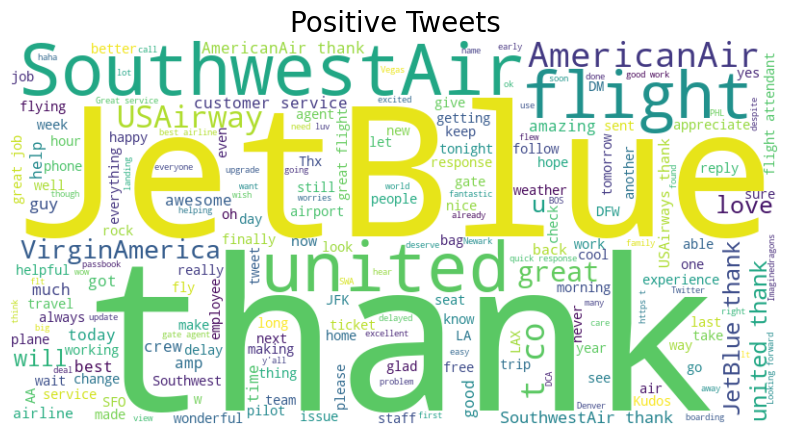

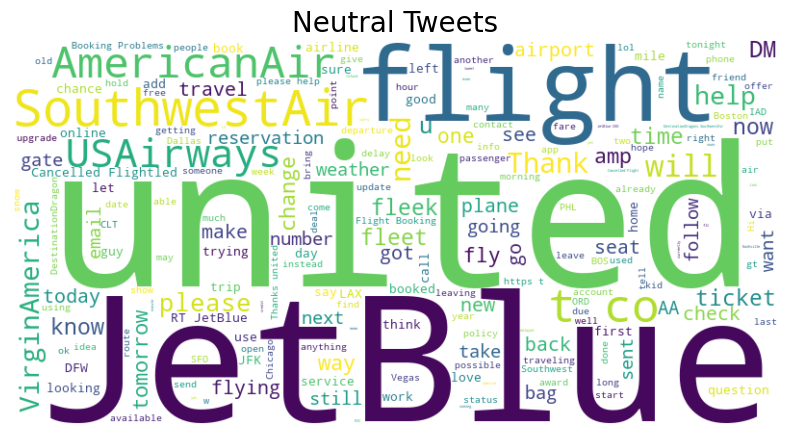

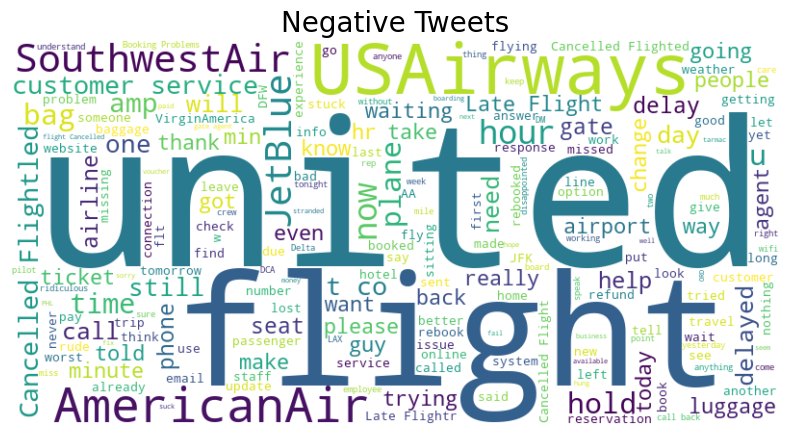

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming `tweets_df` is the DataFrame containing tweet texts and sentiments

# Create DataFrames for each sentiment
positive_tweets = tweets_df[tweets_df['airline_sentiment'] == 2]['text']
neutral_tweets = tweets_df[tweets_df['airline_sentiment'] == 1]['text']
negative_tweets = tweets_df[tweets_df['airline_sentiment'] == 0]['text']

# Generate word clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Convert tweets to text
positive_text = ' '.join(positive_tweets)
neutral_text = ' '.join(neutral_tweets)
negative_text = ' '.join(negative_tweets)

# Display word clouds
generate_wordcloud(positive_text, 'Positive Tweets')
generate_wordcloud(neutral_text, 'Neutral Tweets')
generate_wordcloud(negative_text, 'Negative Tweets')


In [12]:
emoji.demojize('@AmericanAir right on cue with the delays👌')


'@AmericanAir right on cue with the delays:OK_hand:'

In [28]:
ps = PorterStemmer()

def process_tweet(tweet):
    new_tweet = tweet.lower()
    new_tweet = re.sub(r'@\w+', '', new_tweet) # Remove @s
    new_tweet = re.sub(r'#', '', new_tweet) # Remove hashtags
    new_tweet = re.sub(r':', ' ', emoji.demojize(new_tweet)) # Turn emojis into words
    new_tweet = re.sub(r'http\S+', '',new_tweet) # Remove URLs
    new_tweet = re.sub(r'\$\S+', 'dollar', new_tweet) # Change dollar amounts to dollar
    new_tweet = re.sub(r'[^a-z0-9\s]', '', new_tweet) # Remove punctuation
    new_tweet = re.sub(r'[0-9]+', 'number', new_tweet) # Change number values to number
    new_tweet = new_tweet.split(" ")
    new_tweet = list(map(lambda x: ps.stem(x), new_tweet)) # Stemming the words
    new_tweet = list(map(lambda x: x.strip(), new_tweet)) # Stripping whitespace from the words
    if '' in new_tweet:
        new_tweet.remove('')
    return new_tweet

In [29]:
tweets = tweets_df['text'].apply(process_tweet)

labels = np.array(tweets_df['airline_sentiment'])

In [15]:
tweets


0                                           [what, , said]
1        [i, didnt, today, must, mean, i, need, to, tak...
2        [it, realli, aggress, to, blast, obnoxi, enter...
3         [and, it, a, realli, big, bad, thing, about, it]
4        [serious, would, pay, dollar, a, flight, for, ...
                               ...                        
14397           [right, on, cue, with, the, delay, hand, ]
14398    [leav, over, number, minut, late, flight, no, ...
14399    [pleas, bring, american, airlin, to, blackberr...
14400    [you, have, my, money, you, chang, my, flight,...
14401    [we, have, number, ppl, so, we, need, number, ...
Name: text, Length: 14402, dtype: object

In [30]:
# Get size of vocabulary
vocabulary = set()

for tweet in tweets:
    for word in tweet:
        if word not in vocabulary:
            vocabulary.add(word)

vocab_length = len(vocabulary)

# Get max length of a sequence
max_seq_length = 0

for tweet in tweets:
    if len(tweet) > max_seq_length:
        max_seq_length = len(tweet)

# Print results
print("Vocab length:", vocab_length)
print("Max sequence length:", max_seq_length)

Vocab length: 11250
Max sequence length: 90


In [17]:
tokenizer = Tokenizer(num_words=vocab_length)
tokenizer.fit_on_texts(tweets)

sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index

model_inputs = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

In [18]:
model_inputs


array([[  49,    2,  218, ...,    0,    0,    0],
       [   5,  191,  102, ...,    0,    0,    0],
       [  15,  138, 2841, ...,    0,    0,    0],
       ...,
       [  76,  507,  435, ...,    0,    0,    0],
       [   8,   19,   12, ...,    0,    0,    0],
       [  37,   19,    4, ...,    0,    0,    0]])

In [19]:
model_inputs.shape



(14402, 90)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(model_inputs, labels, train_size=0.7, random_state=22)
#splitting into the training and testing sets

Random Forest Metrics:
               precision    recall  f1-score   support

           0       0.72      0.94      0.82      2797
           1       0.49      0.27      0.35       869
           2       0.66      0.22      0.33       655

    accuracy                           0.70      4321
   macro avg       0.63      0.48      0.50      4321
weighted avg       0.67      0.70      0.65      4321

Support Vector Machine Metrics:
               precision    recall  f1-score   support

           0       0.65      0.99      0.79      2797
           1       0.52      0.04      0.07       869
           2       0.50      0.00      0.00       655

    accuracy                           0.65      4321
   macro avg       0.56      0.34      0.29      4321
weighted avg       0.60      0.65      0.52      4321

Naive Bayes Metrics:
               precision    recall  f1-score   support

           0       0.81      0.43      0.57      2797
           1       0.26      0.45      0.33       

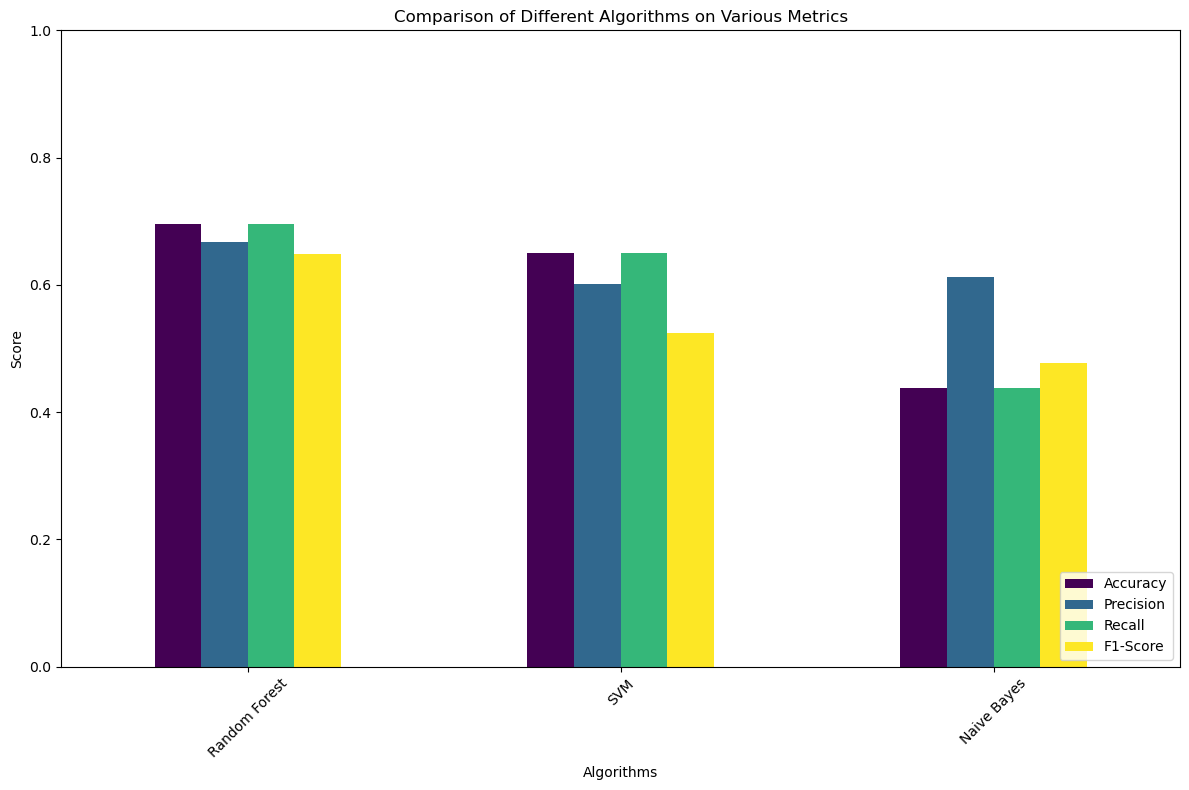

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Assuming X_train, X_test, y_train, y_test are already defined

# Initialize classifiers
random_forest = RandomForestClassifier()
svm = SVC()
naive_bayes = MultinomialNB()

# Train classifiers
random_forest.fit(X_train, y_train)
svm.fit(X_train, y_train)
naive_bayes.fit(X_train, y_train)

# Predict using trained classifiers
y_pred_rf = random_forest.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_nb = naive_bayes.predict(X_test)

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_nb = accuracy_score(y_test, y_pred_nb)

precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')

recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
recall_nb = recall_score(y_test, y_pred_nb, average='weighted')

f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

# Print metrics
print("Random Forest Metrics:\n", classification_report(y_test, y_pred_rf))
print("Support Vector Machine Metrics:\n", classification_report(y_test, y_pred_svm))
print("Naive Bayes Metrics:\n", classification_report(y_test, y_pred_nb))

# Combine all metrics for plotting
metrics = {
    'Algorithm': ['Random Forest', 'SVM', 'Naive Bayes'],
    'Accuracy': [accuracy_rf, accuracy_svm, accuracy_nb],
    'Precision': [precision_rf, precision_svm, precision_nb],
    'Recall': [recall_rf, recall_svm, recall_nb],
    'F1-Score': [f1_rf, f1_svm, f1_nb]
}

metrics_df = pd.DataFrame(metrics)

# Plot metrics
metrics_df.set_index('Algorithm').plot(kind='bar', figsize=(12, 8), ylim=(0, 1), colormap='viridis')
plt.title('Comparison of Different Algorithms on Various Metrics')
plt.ylabel('Score')
plt.xlabel('Algorithms')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### TRAINING

Random Forest Metrics:
               precision    recall  f1-score   support

           0       0.72      0.94      0.82      2797
           1       0.50      0.26      0.34       869
           2       0.63      0.21      0.31       655

    accuracy                           0.69      4321
   macro avg       0.62      0.47      0.49      4321
weighted avg       0.66      0.69      0.64      4321

Support Vector Machine Metrics:
               precision    recall  f1-score   support

           0       0.65      0.99      0.79      2797
           1       0.52      0.04      0.07       869
           2       0.50      0.00      0.00       655

    accuracy                           0.65      4321
   macro avg       0.56      0.34      0.29      4321
weighted avg       0.60      0.65      0.52      4321

Naive Bayes Metrics:
               precision    recall  f1-score   support

           0       0.81      0.43      0.57      2797
           1       0.26      0.45      0.33       

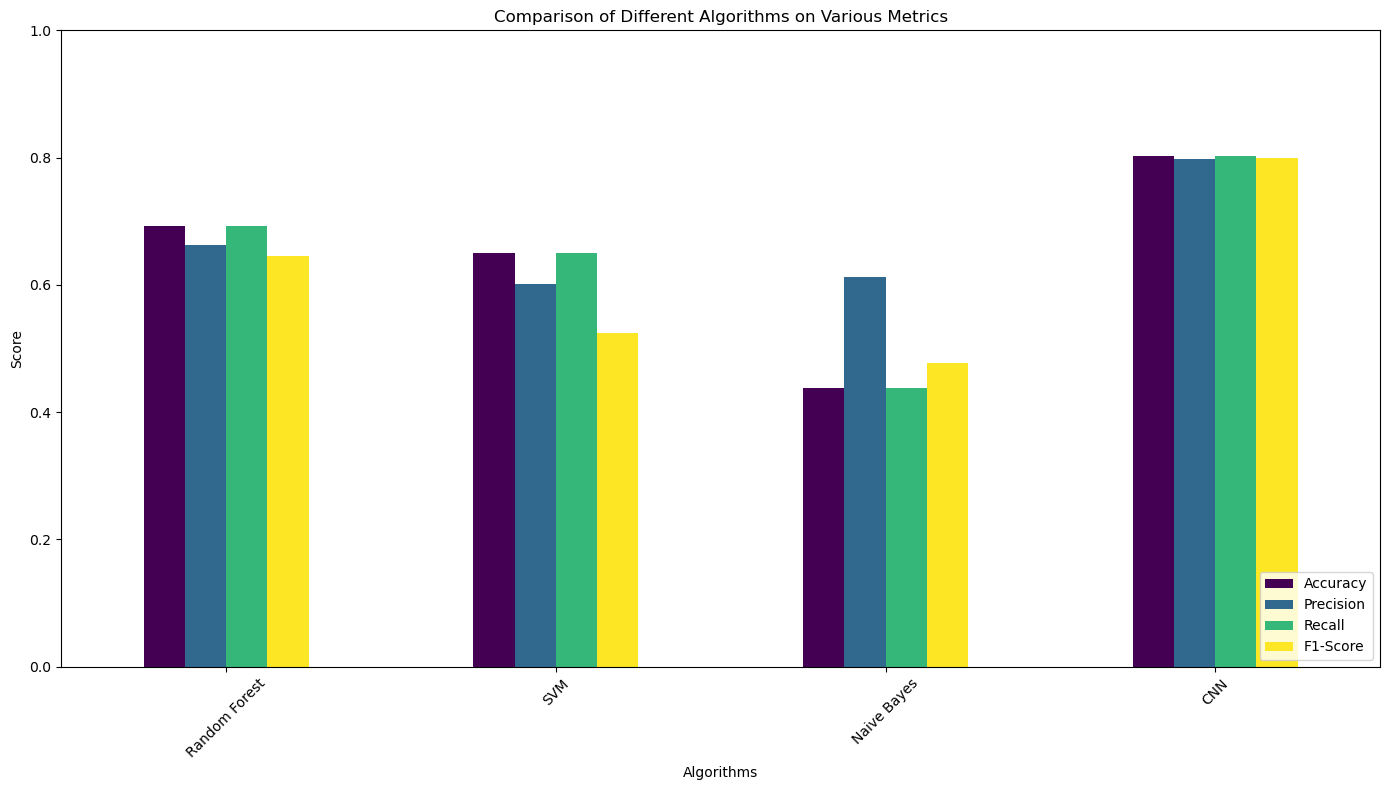

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming X_train, X_test, y_train, y_test are already defined

# Initialize and train classifiers
random_forest = RandomForestClassifier()
svm = SVC()
naive_bayes = MultinomialNB()

random_forest.fit(X_train, y_train)
svm.fit(X_train, y_train)
naive_bayes.fit(X_train, y_train)

# Predict using trained classifiers
y_pred_rf = random_forest.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_nb = naive_bayes.predict(X_test)

# Calculate metrics for the classical ML models
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')
recall_nb = recall_score(y_test, y_pred_nb, average='weighted')
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

# Print metrics
print("Random Forest Metrics:\n", classification_report(y_test, y_pred_rf))
print("Support Vector Machine Metrics:\n", classification_report(y_test, y_pred_svm))
print("Naive Bayes Metrics:\n", classification_report(y_test, y_pred_nb))

# CNN Model
embedding_dim = 32
inputs = tf.keras.Input(shape=(max_seq_length,))
embedding = tf.keras.layers.Embedding(input_dim=vocab_length, output_dim=embedding_dim)(inputs)

# Model A (Flatten)
flatten = tf.keras.layers.Flatten()(embedding)

# Model B (GRU + Flatten)
gru = tf.keras.layers.GRU(units=embedding_dim)(embedding)
gru_flatten = tf.keras.layers.Flatten()(gru)

# Concatenate and Output
concat = tf.keras.layers.concatenate([flatten, gru_flatten])
outputs = tf.keras.layers.Dense(3, activation='softmax')(concat)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train CNN Model
batch_size = 32
epochs = 100

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

# Evaluate CNN Model
cnn_metrics = model.evaluate(X_test, y_test)
accuracy_cnn = cnn_metrics[1]

y_pred_cnn = np.argmax(model.predict(X_test), axis=-1)
precision_cnn = precision_score(y_test, y_pred_cnn, average='weighted')
recall_cnn = recall_score(y_test, y_pred_cnn, average='weighted')
f1_cnn = f1_score(y_test, y_pred_cnn, average='weighted')

# Print CNN metrics
print("CNN Metrics:\n", classification_report(y_test, y_pred_cnn))

# Combine all metrics for plotting
metrics = {
    'Algorithm': ['Random Forest', 'SVM', 'Naive Bayes', 'CNN'],
    'Accuracy': [accuracy_rf, accuracy_svm, accuracy_nb, accuracy_cnn],
    'Precision': [precision_rf, precision_svm, precision_nb, precision_cnn],
    'Recall': [recall_rf, recall_svm, recall_nb, recall_cnn],
    'F1-Score': [f1_rf, f1_svm, f1_nb, f1_cnn]
}

metrics_df = pd.DataFrame(metrics)

# Plot metrics
metrics_df.set_index('Algorithm').plot(kind='bar', figsize=(14, 8), ylim=(0, 1), colormap='viridis')
plt.title('Comparison of Different Algorithms on Various Metrics')
plt.ylabel('Score')
plt.xlabel('Algorithms')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



In [73]:
# Sample test sentence
test_sentence = "This airline provides excellent service and comfortable flights."

# Preprocess the test sentence
processed_test_sentence = process_tweet(test_sentence)

# Convert the processed test sentence to a sequence
test_sequence = tokenizer.texts_to_sequences([processed_test_sentence])

# Pad the test sequence
padded_test_sequence = pad_sequences(test_sequence, maxlen=max_seq_length, padding='post')

# Random Forest
print("Random Forest Predicted Sentiment:", sentiment_ordering[random_forest.predict(padded_test_sequence)[0]])

# SVM
print("SVM Predicted Sentiment:", sentiment_ordering[svm.predict(padded_test_sequence)[0]])

# Naive Bayes
print("Naive Bayes Predicted Sentiment:", sentiment_ordering[naive_bayes.predict(padded_test_sequence)[0]])

# CNN
cnn_prediction = model.predict(padded_test_sequence)
print("CNN Predicted Sentiment:", sentiment_ordering[np.argmax(cnn_prediction)])


Random Forest Predicted Sentiment: neutral
SVM Predicted Sentiment: negative
Naive Bayes Predicted Sentiment: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
CNN Predicted Sentiment: positive


In [80]:
# Sample test sentence
test_sentence = "This airline provides service and uncomfortable flights."

# Preprocess the test sentence
processed_test_sentence = process_tweet(test_sentence)

# Convert the processed test sentence to a sequence
test_sequence = tokenizer.texts_to_sequences([processed_test_sentence])

# Pad the test sequence
padded_test_sequence = pad_sequences(test_sequence, maxlen=max_seq_length, padding='post')

# Random Forest
print("Random Forest Predicted Sentiment:", sentiment_ordering[random_forest.predict(padded_test_sequence)[0]])

# SVM
print("SVM Predicted Sentiment:", sentiment_ordering[svm.predict(padded_test_sequence)[0]])

# Naive Bayes
print("Naive Bayes Predicted Sentiment:", sentiment_ordering[naive_bayes.predict(padded_test_sequence)[0]])

# CNN
cnn_prediction = model.predict(padded_test_sequence)
print("CNN Predicted Sentiment:", sentiment_ordering[np.argmax(cnn_prediction)])

Random Forest Predicted Sentiment: neutral
SVM Predicted Sentiment: negative
Naive Bayes Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
CNN Predicted Sentiment: negative


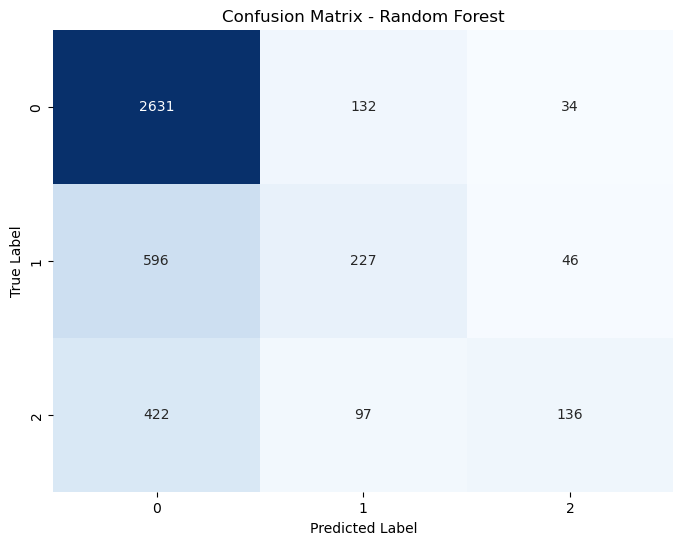

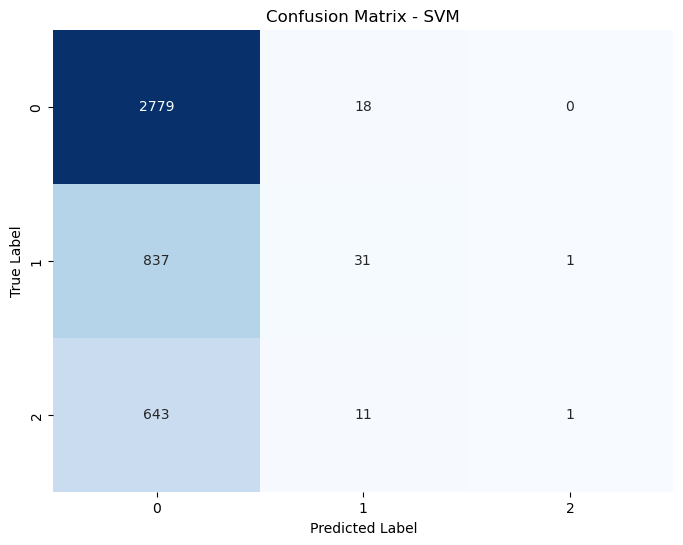

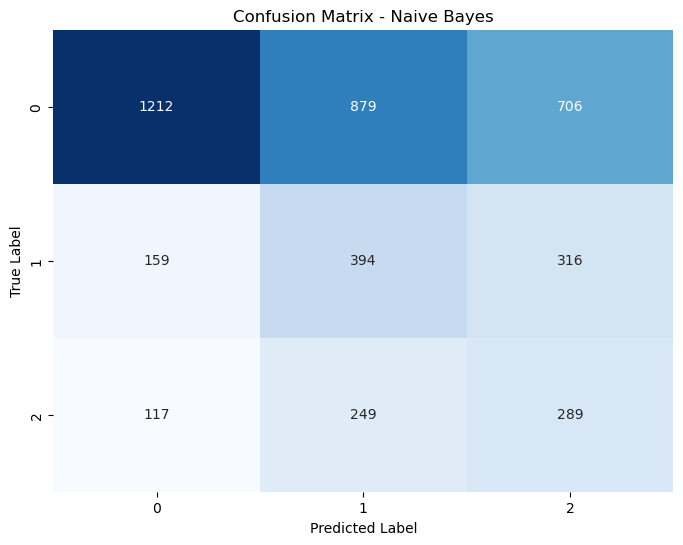

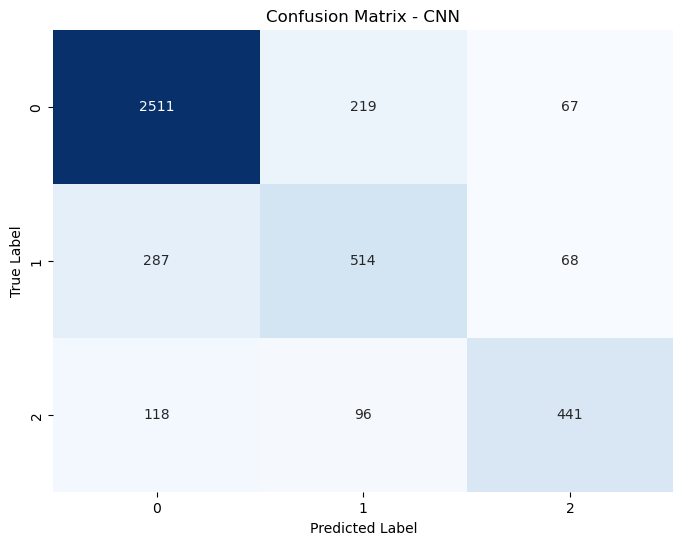

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Confusion matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Confusion matrix for CNN
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
